In [1]:
#Importing Libraries
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,TimeDistributed,Bidirectional,Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
#import the librearies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
np.random.seed(1120)

In [12]:
import yfinance as yf
import datetime
aapl=yf.Ticker('^NSEI')
date=datetime.datetime.now()
date=date.strftime("%Y-%m-%d")
df=aapl.history(start="2010-01-01", end=date)
df.tail(14)
df.to_csv('nifty.csv')

In [3]:
data=df.filter(['Close'])
#convert the dataframe to numpy array
dataset=data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*0.8)

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [5]:
scaled_data=np.array(scaled_data)
scaled_data=np.reshape(scaled_data,(len(scaled_data),1))

In [6]:
train_data=scaled_data[0:training_data_len,:]

In [7]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    #X = np.reshape(X,(len(X),window_size,1))
    X=X.reshape(X.shape[0],window_size,1)
    Y = np.reshape(Y,(len(Y),1))
    return X, Y
def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    print('\nWindow Size: ', window_size)
    if window_size == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM-CNN model and predict on validation set
    model = Sequential()
    #add model layers
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(window_size,1)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60,
    1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train,y_train,epochs=5, verbose=0)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,
#genetic algorithm for predicting stock
population_size = 4
num_generations = 4
gene_length = 10

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1,ngen = num_generations, verbose = False)


Window Size:  36
17/17 [==============================] - 1s 13ms/step
Validation RMSE:  0.01682359354162286 


Window Size:  56
17/17 [==============================] - 1s 20ms/step
Validation RMSE:  0.02314122091434516 


Window Size:  60
17/17 [==============================] - 2s 16ms/step
Validation RMSE:  0.016430751652254914 


Window Size:  49
17/17 [==============================] - 1s 21ms/step
Validation RMSE:  0.0173345126750545 


Window Size:  56
17/17 [==============================] - 1s 24ms/step
Validation RMSE:  0.0189149101197496 


Window Size:  56
17/17 [==============================] - 1s 24ms/step
Validation RMSE:  0.0202906027448541 


Window Size:  48
17/17 [==============================] - 1s 21ms/step
Validation RMSE:  0.01942788554750773 


Window Size:  37
17/17 [==============================] - 1s 13ms/step
Validation RMSE:  0.015126945662019017 


Window Size:  32
17/17 [==============================] - 1s 12ms/step
Validation RMSE:  0.0146502771106

In [8]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
#best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    #num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    #best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size)


Window Size:  48


In [9]:
#Create the training dataset
#Create the scaled training dataset
#Split the data into x_train and y_train data sets
x_train=[]
y_train=[]
for i in range(best_window_size,len(train_data)):
    x_train.append(train_data[i-best_window_size:i,0])
    y_train.append(train_data[i,0])
#Create the testing data set
#Create a new array containing scaled values from index 2101 to 2701
test_data=scaled_data[training_data_len-best_window_size:,:]
#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(best_window_size,len(test_data)):
    x_test.append(test_data[i-best_window_size:i,0])

In [10]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
#Convert the data to a numpy array
x_test=np.array(x_test)
#reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [11]:
# Defining model Architecture
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60,
1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=["accuracy"])
model.fit(x_train,y_train,epochs=20, verbose=0)
model.save('m3.h5')

In [12]:
from keras.models import load_model
model = load_model('m3.h5')

In [13]:
model.fit(x_train,y_train,epochs=20, verbose=0)

In [14]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

21/21 [==============================] - 0s 7ms/step


C:\Users\HOME\AppData\Local\Temp\ipykernel_8252\451340258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction']=predictions


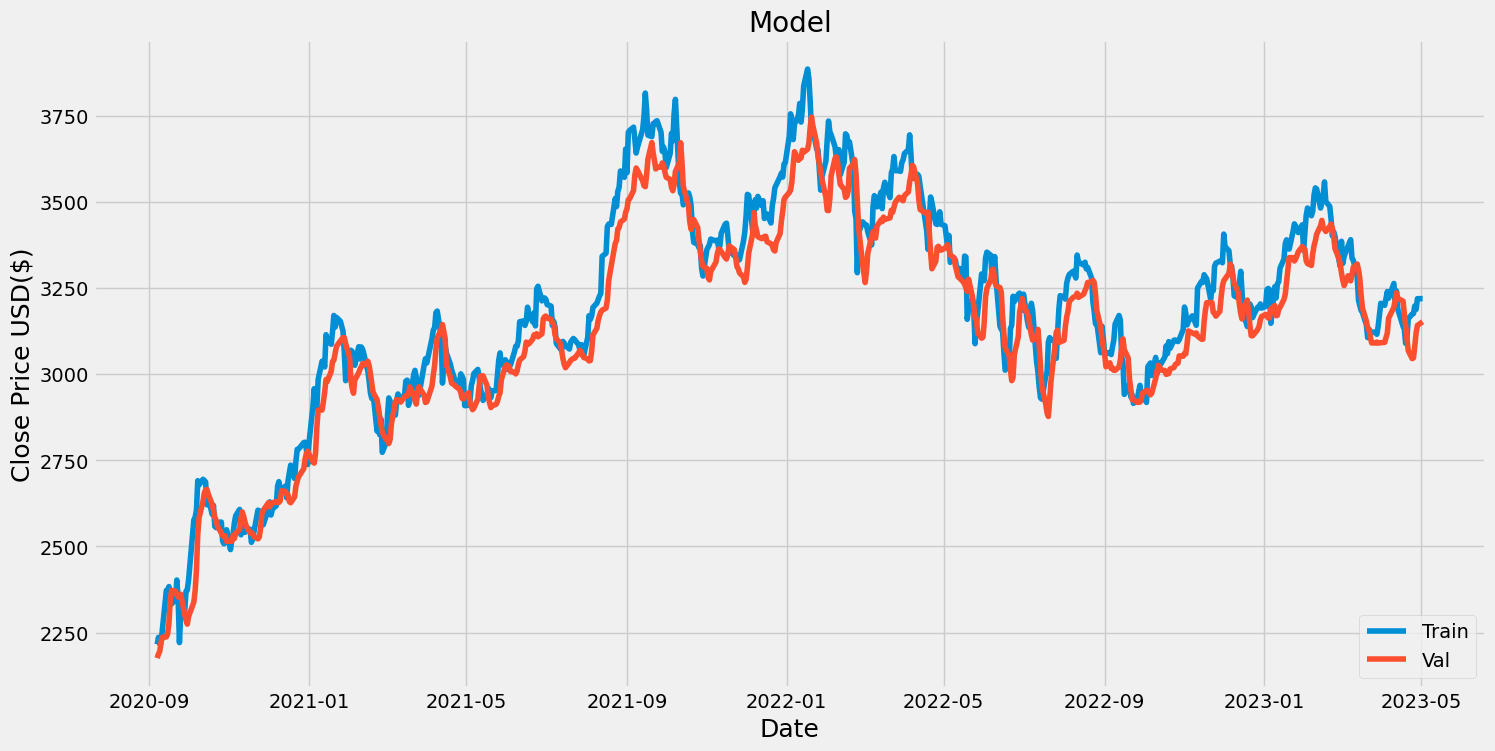

In [15]:
#Plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediction']=predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Prediction'],loc='lower right')
plt.show()

In [16]:
x_input=scaled_data[len(data)-best_window_size:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [17]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=best_window_size
i=0
while(i<365):
    
    if(len(temp_input)>best_window_size):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [18]:
lst_output=np.array(lst_output)
lst_output=scaler.inverse_transform(lst_output)

In [19]:
import datetime
shreyas=[]
date = datetime.datetime.now()
for i in range(365):
    shreyas.append(date)
    date += datetime.timedelta(days=1)
    if(date.weekday()==5):
        date += datetime.timedelta(days=2)

In [20]:
# import pandas library as pd
import pandas as pd
  
# create an Empty DataFrame object With
# column names and indices
df = pd.DataFrame(columns = ['Close','Date'],
        index = shreyas)

In [21]:
predy=lst_output.reshape(365,)
df['Close']=predy
df['Date']=shreyas
df

,Close,Date
2023-05-03 09:47:38.837188,3158.726898,2023-05-03 09:47:38.837188
2023-05-04 09:47:38.837188,3170.304475,2023-05-04 09:47:38.837188
2023-05-05 09:47:38.837188,3143.597832,2023-05-05 09:47:38.837188
2023-05-08 09:47:38.837188,3129.584346,2023-05-08 09:47:38.837188
2023-05-09 09:47:38.837188,3109.563847,2023-05-09 09:47:38.837188
...,...,...
2024-09-18 09:47:38.837188,2367.965911,2024-09-18 09:47:38.837188
2024-09-19 09:47:38.837188,2367.918926,2024-09-19 09:47:38.837188
2024-09-20 09:47:38.837188,2367.872803,2024-09-20 09:47:38.837188
2024-09-23 09:47:38.837188,2367.826679,2024-09-23 09:47:38.837188


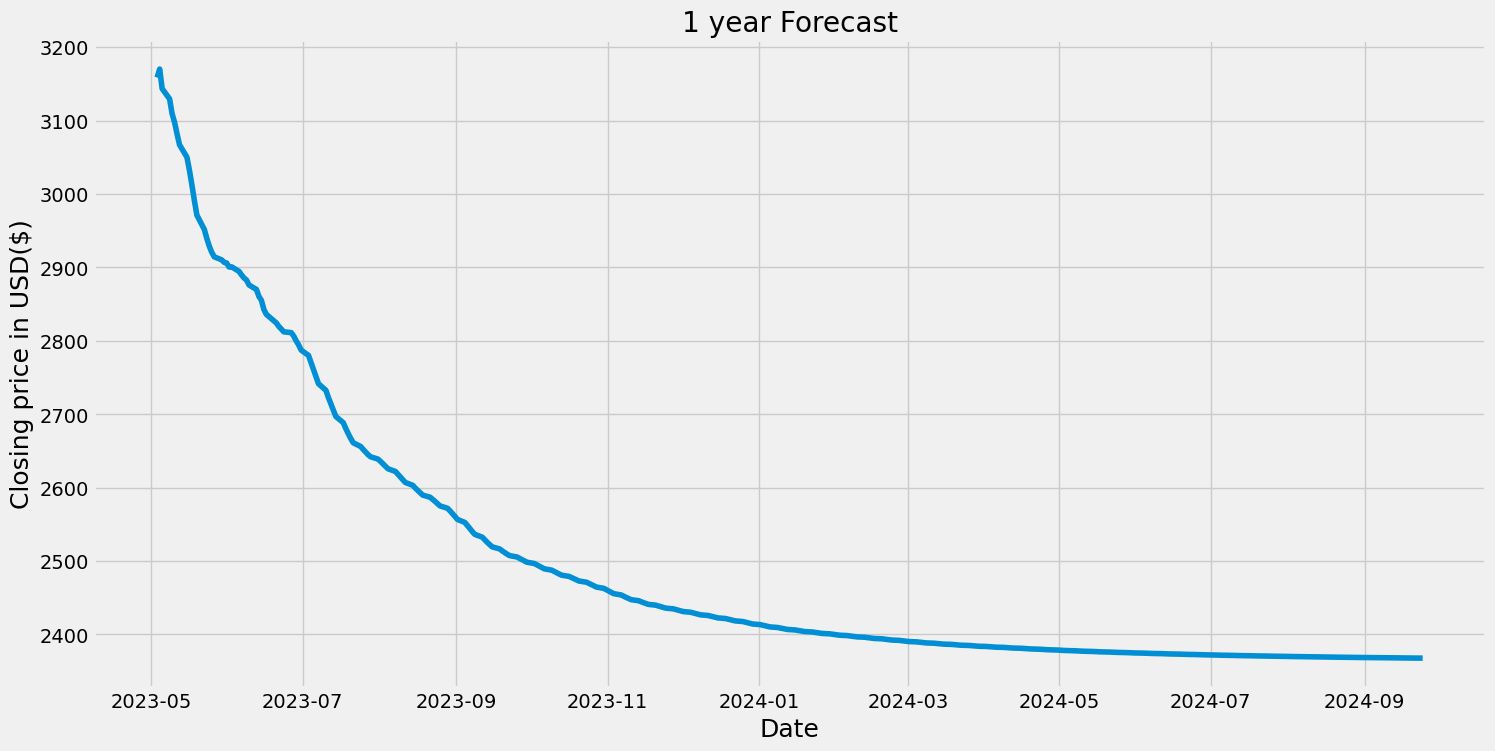

In [22]:
#visualize the closing price
plt.figure(figsize=(16,8))
plt.title('1 year Forecast')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing price in USD($)',fontsize=18)
plt.show()